In [ ]:
import os
import sys

sys.path.append(os.path.abspath("..")) # make src available as a package




In [ ]:
SEED = int(os.getenv("SEED", 42))

import random
import numpy as np
import torch
import datasets

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# TODO: check if this was all?
# TODO: what about CUDNN flags?

# 1. Dataset Preparation

In [ ]:
from src.data import mMARCO

batch_size = 32

# only used for testing here, use the dataloaders otherwise
mmarco = mMARCO(seed=SEED, shuffle_buffer_size=64, shuffle=False)
print(mmarco._data.info.splits)

for sample in mmarco:
    print(sample)
    break

None
{'query': 'is a little caffeine ok during pregnancy', 'positive': 'We donâ\x80\x99t know a lot about the effects of caffeine during pregnancy on you and your baby. So itâ\x80\x99s best to limit the amount you get each day. If youâ\x80\x99re pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1Â½ 8-ounce cups of coffee or one 12-ounce cup of coffee.', 'negative': 'It is generally safe for pregnant women to eat chocolate because studies have shown to prove certain benefits of eating chocolate during pregnancy. However, pregnant women should ensure their caffeine intake is below 200 mg per day.'}


# 2. Training

In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for Apple's Metal (MPS) backend / framework
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Using device: {device}")

Using device: cuda


Pointwise cross-encoders are supposed to output a class label (e.g., *relevant*
or *not-relevant*) or a relevance score (e.g., from 0 to 1). Now, this model
returns raw logits (practically a relevance score). However, the dataset does
not have any gold labels, which could be used to compute a loss.

Fortunately, the `(query, positive, negative)` triplets can easily be framed as
such:
- `(query, positive)=1` now means *relevant*
- `(query, negative)=0` now means *not-relevant*

Et voilà, this can be used for trainig.

During training, we have to apply sigmoid to the raw logits to get a binary
score though. However, during inference, we want the raw logits to build a
sorted ranking.

NOTE: There are quite a few CEL functions...
- `nn.CrossEntropyLoss` 
  - **use case**: multi-class classification
  - **input**: raw logits for each class (`input`), and the target class indices (`target`).
- `nn.BCELoss`
  - **use case**: binary classification or multi-label classification (independent classes)
  - **input**: probabilities (so sigmoid must already be applied) and the target class indices (`target`).
- `nn.BCEWithLogitsLoss` ← ✅
  - **use case**: binary classification or multi-label classification (independent classes)
  - **input**: raw logits (so sigmoid is applied internally), and the target class indices (`target`).


### Hyperparameters

In [ ]:
from src.models import CrossEncoderBERT
import torch.optim as optim
import torch.nn as nn

padding = "longest"
max_length = 512

model = CrossEncoderBERT(
    # enable_gradient_checkpointing=True,
)
criterion = nn.BCEWithLogitsLoss()
# learning_rate = 2e-5
learning_rate = 1e-5
epochs = 5
# epochs = 20
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


train_dl, val_dl, test_dl = mmarco.as_dataloaders(seed=SEED, batch_size=batch_size, max_samples_per_split=20_000)

### Progress Bars & Stats

In [ ]:
from string import Formatter
from typing import Any, Callable
import ipywidgets as widgets

progress_widget = widgets.IntProgress(
    value=0,
    min=0,
    max=epochs,
    description=f"Epoch: 0/{epochs}",
)

def update_progress(epoch: int):
    progress_widget.value = epoch + 1
    progress_widget.description = f"Epoch: {epoch + 1}/{epochs}"
    

training_loss_widget = widgets.FloatProgress(
    value=1,
    min=0.0,
    max=1.0,
    description="Train: 1.0",
    bar_style="",
    style={"bar_color": "red"},
)

val_loss_widget = widgets.FloatProgress(
    value=1,
    min=0.0,
    max=1.0,
    description="Val: 1.0",
    bar_style="",
    style={"bar_color": "red"},
)


def update_loss(loss: float, widget: widgets.FloatProgress, name: str = "Loss"):
    widget.value = loss
    widget.description = f"{name}: {loss:.3f}"

    match loss:
        case loss if loss <= 0.1:
            widget.style["bar_color"] = "green"
        case loss if loss < 0.3:
            widget.style["bar_color"] = "yellow"
        case loss if loss < 0.5:
            widget.style["bar_color"] = "orange"
        case _:
            widget.style["bar_color"] = "red"

class Label:

    def __init__(self, name: str = "Label: {value}", *, show: bool = True, transform: Callable[[str | int | float], str | int | float] | None = None) -> None:
        self.name = name
        self.tmpl = Formatter().parse(name)

        placerholders = [field_name for _, field_name, _, _ in self.tmpl if field_name]
        if "value" not in placerholders:
            raise ValueError("The format string 'name' must contain a 'value' placeholder.")

        self.widget = widgets.Label(
            value=self.name.format(value=0)
        )
        self.transform = transform

        if show:
            display(self.widget)

    def _render(self, value: Any):
        if self.transform:
            value = self.transform(value)
        self.widget.value = self.name.format(value=value)

    def set(self, count: str | int | float):
        self._render(count)

class Counter(Label):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.count: int | float = 0

    def update(self, count: int | float):
        self.count += count
        self._render(self.count)

    def inc(self):
        self.update(1)

    def clear(self):
        self.count = 0
        self._render(self.count)

In [ ]:
from dataclasses import dataclass, field
from datetime import datetime
import math
from typing import Any

@dataclass
class Stats:

    start: datetime = field(default_factory=datetime.now)
    end: datetime | None = None
    elapsed: float | None = None # in seconds

    # capture each batch loss, group by epoch
    train_losses: list[list[float]] = field(default_factory=lambda: [[] for _ in range(epochs)])
    val_losses: list[list[float]] = field(default_factory=lambda: [[] for _ in range(epochs)])
    test_losses: list[list[float]] = field(default_factory=lambda: [[] for _ in range(epochs)])

    def _get_losses(self, split: str, epoch: int) -> list[float]:
        match split:
            case "train":
                return self.train_losses[epoch]
            case "val":
                return self.val_losses[epoch]
            case "test":
                return self.test_losses[epoch]
            case _:
                raise ValueError(f"Unknown split: {split}")

    def mean(self, split: str, epoch: int, window: int | None = None) -> float:
        """Mean loss. If window is None, use full epoch; if 0, also full epoch; else use last `window` losses."""
        losses = self._get_losses(split, epoch)
        if window is None or window == 0:
            windowed = losses[:]
        else:
            windowed = losses[-window:]
        return sum(windowed) / len(windowed) if windowed else 0.0

    # Window = last `window` losses; used to create a rolling stddev
    # Set to `0` to use all losses in the epoch
    def stddev(self, split: str, epoch: int, window: int = 100) -> float:
        losses = self._get_losses(split, epoch)
        windowed = losses[:] if window == 0 else losses[-window:]

        if not windowed:
            return 0.0

        mean = sum(windowed) / len(windowed)
        variance = sum((x - mean) ** 2 for x in windowed) / len(windowed)
        return math.sqrt(variance)

    # Window = last `window` losses; CV computed using the same window for mean by default
    def CV(self, split: str, epoch: int, window: int = 100, use_same_window_for_mean: bool = True) -> float:
        stddev = self.stddev(split, epoch, window)
        mean = self.mean(split, epoch, window if use_same_window_for_mean else None)
        return (stddev / mean) if mean != 0 else 0.0

    def stop(self):
        self.end = datetime.now()
        self.elapsed = (self.end - self.start).total_seconds()
        return self.elapsed

### Training Loop

CV (coefficient of variance) interpretation:
- < 10-20%: low variance (stable training)
- \> 20-40%: high variance (possible training instability)

Standard Deviation interpretation: 
- stable losses are generally within ±5% of the mean

Good validation loss (CEL):

**NOTE: Some fluctuation in batch loss is expected, especially during early training!**

In [ ]:
from datetime import datetime
from typing import cast

from transformers import BatchEncoding
from src.data.mmarco import mMARCOBatch
from IPython.display import display
import torch.nn as nn

stats = Stats()

# convenience function
def tokenize(batch: mMARCOBatch):
    return model.tokenize(
        batch["queries"],  # pyright: ignore[reportGeneralTypeIssues]
        batch["candidates"],  # pyright: ignore[reportGeneralTypeIssues]
        padding=padding,
        max_length=max_length,
    ).to(device)

# convenience function
def feed(input: BatchEncoding):
    return input["input_ids"], input["attention_mask"], input["token_type_ids"],  # type: ignore
    

# print stats and display widgets
time_label = Label(f"Start: {stats.start.strftime('%H:%M:%S')}" + " Stop: {value}", show=False)
# used for both training and validation ...
batch_counter = Counter("Batches: {value}", show=False) # batches seen per epoch
iter_counter = Counter("Iterations: {value}", show=False) # samples seen per epoch

# NOTE: two additional labels for training and validation loss with
# the momentary values are defined aboth

# Mean loss per epoch (NO rolling window)
train_mean_loss_label = Label("L\u0305: {value:.4f}", show=False) # Mean Loss per epoch
val_mean_loss_label = Label("L\u0305: {value:.4f}", show=False) # Mean Loss per epoch

# Standard Deviation per epoch (rolling window for training)
train_deviation_label = Label("σ: {value:.4f}", show=False)
val_deviation_label = Label("σ: {value:.4f}", show=False)

# Coefficient of Variation per epoch (rolling window for training)
train_cv_label = Label("CV: {value:.2f}%", show=False, transform=lambda x: x * 100) 
val_cv_label = Label("CV: {value:.2f}%", show=False, transform=lambda x: x * 100)

display(widgets.VBox([
    widgets.HBox([time_label.widget]),
    widgets.HBox([progress_widget, batch_counter.widget, iter_counter.widget]),
    widgets.HBox([training_loss_widget, train_mean_loss_label.widget, train_deviation_label.widget, train_cv_label.widget]),
    widgets.HBox([val_loss_widget, val_mean_loss_label.widget, val_deviation_label.widget, val_cv_label.widget])
]))

# GPU => prefer bfloat16, so no GradScaler needed
# CPU/MPS => stick to FP32 (no autocast)
dtype = torch.bfloat16 if device.type == "cuda" else torch.float32
autocast_enabled = device.type == "cuda" # assume GPU is Ampere or later
model.to(device)

for epoch in range(epochs):

    # --- training loop ---
    model.train()
    for batch in train_dl:
        batch = cast(mMARCOBatch, batch)    
        input = tokenize(batch)

        optimizer.zero_grad()

        with torch.autocast(device_type=device.type, dtype=dtype, enabled=autocast_enabled):
            logits = model(*feed(input)).squeeze(-1)
            loss = criterion(logits, batch["labels"].float().to(device))

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # prevent exploding gradients
        optimizer.step()

        # - update stats -
        stats.train_losses[epoch].append(loss.item())
        # - update widgets -
        iter_counter.update(len(batch["queries"]))
        batch_counter.inc()
        update_loss(loss.item(), training_loss_widget, "Train")
        train_mean_loss_label.set(stats.mean("train", epoch, window=0))
        train_deviation_label.set(stats.stddev("train", epoch, window=100))
        train_cv_label.set(stats.CV("train", epoch, window=100))


    # after each epoch, reset some widgets / counters
    batch_counter.clear()
    iter_counter.clear()

    # --- validation loop ---
    model.eval()
    val_loss = 0.0 # cumulative loss
    val_samples = 0

    with torch.no_grad():
        for batch in val_dl:
            batch = cast(mMARCOBatch, batch)    
            input = tokenize(batch)
            logits = model(*feed(input)).squeeze(-1)
            loss = criterion(logits, batch["labels"].float().to(device))

            # - update stats -
            s = len(batch["queries"])
            val_loss += loss.item() * s
            val_samples += s
            stats.val_losses[epoch].append(loss.item())

            # - update widgets -
            iter_counter.update(len(batch["queries"]))
            batch_counter.inc()
            update_loss(loss.item(), val_loss_widget, "Val")
            val_mean_loss_label.set(stats.mean("val", epoch, window=0))
            val_deviation_label.set(stats.stddev("val", epoch, window=0))
            val_cv_label.set(stats.CV("val", epoch, window=0))


    val_loss /= val_samples if val_samples > 0 else float("nan")
    update_progress(epoch)

    # after each epoch, reset some widgets / counters
    batch_counter.clear()
    iter_counter.clear()
            
    
model.eval()
stats.stop()
time_label.set(f"{stats.end.strftime('%H:%M:%S')} ({(stats.elapsed/60):.1f}min)") # pyright: ignore[reportOptionalOperand, reportOptionalMemberAccess]

After the training (and validation) cycles are done,
the reamaining test set is used to report the final
performance.

In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_dl:
        ...

### Saving The Model

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingMetadata:

# def gather_metadata() -> TrainingMetadata:


# def save_model(metadata):


# def save_training

In [25]:
stop_rfc3339 = stats.end.strftime('%Y-%m-%dT%H:%M:%S%Z') # pyright: ignore[reportOptionalMemberAccess]
filename = f"cross-encoder_pointwise_{stop_rfc3339}.pth"

torch.save(model.state_dict(), filename)

# and later load with:
# model = CrossEncoderBERT()
# model.load_state_dict(torch.load("model_state.pth"))
# model.eval()

### Plotting & Detailed Trainings Run Analysis

NOTE: NaNs have occured during training, I believe it's likely
due to gradient clipping = loss becomes numberically unstable.

TODO: To prevent runtime errors when using the model later on,
the `Stats` class should ideally fix this by removing NaNs
from the recorded losses.

Epoch 01 | Train: 0.2826 ± 0.1121 (n=625) | Val: 0.2515 ± 0.1010 (n=625)
Epoch 02 | Train: 0.1376 ± 0.0866 (n=625) | Val: 0.2617 ± 0.1354 (n=625)
Epoch 03 | Train: 0.0824 ± 0.0728 (n=625) | Val: 0.3733 ± 0.1945 (n=625)
Epoch 04 | Train: 0.0497 ± 0.0611 (n=625) | Val: 0.4082 ± 0.2248 (n=625)
Epoch 05 | Train: 0.0391 ± 0.0537 (n=625) | Val: 0.3945 ± 0.2346 (n=625)


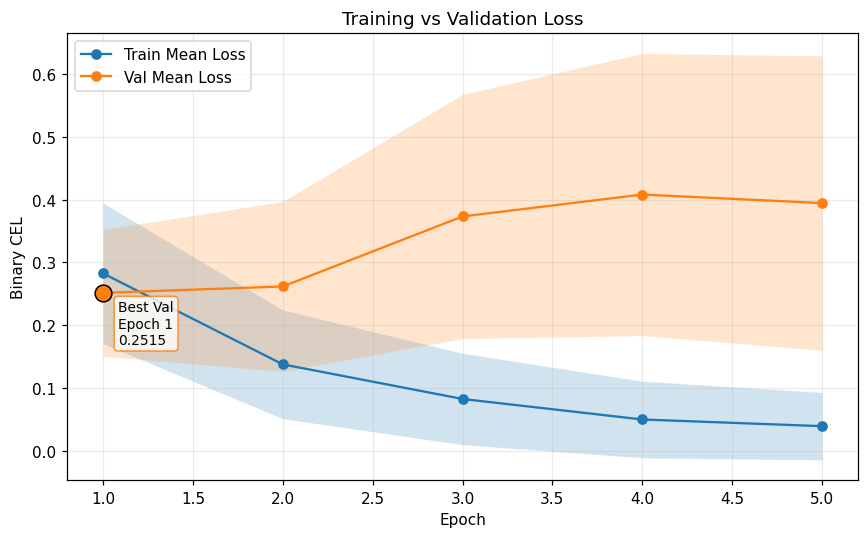

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence

def _summarize(loss_matrix: Sequence[Sequence[float]]):
    """Helper to summarize a matrix of losses (list of lists) into means, stds, and counts per epoch."""
    means: list[float] = []
    stds: list[float] = []
    counts: list[int] = []
    for losses in loss_matrix:
        if len(losses) == 0:
            means.append(float("nan"))
            stds.append(float("nan"))
            counts.append(0)
        else:
            arr = np.asarray(losses, dtype=float)
            means.append(float(arr.mean()))
            stds.append(float(arr.std(ddof=0)))  # population std for stability
            counts.append(len(arr))
    return means, stds, counts

train_means, train_stds, train_counts = _summarize(stats.train_losses)
val_means, val_stds, val_counts = _summarize(stats.val_losses)

epochs_axis = np.arange(1, len(stats.train_losses) + 1)

fig, ax = plt.subplots(figsize=(8, 5), dpi=110)

# Plot lines
ax.plot(epochs_axis, train_means, marker='o', label='Train Mean Loss', color='C0')
ax.plot(epochs_axis, val_means, marker='o', label='Val Mean Loss', color='C1')

# Std deviation bands (ignore NaNs automatically by masking)
train_upper = np.array(train_means) + np.array(train_stds)
train_lower = np.array(train_means) - np.array(train_stds)
val_upper = np.array(val_means) + np.array(val_stds)
val_lower = np.array(val_means) - np.array(val_stds)

ax.fill_between(epochs_axis, train_lower, train_upper, color='C0', alpha=0.20, linewidth=0)
ax.fill_between(epochs_axis, val_lower, val_upper, color='C1', alpha=0.20, linewidth=0)

# Highlight best (lowest) validation epoch
if any(not math.isnan(v) for v in val_means):
    best_epoch_idx = int(np.nanargmin(val_means))
    ax.scatter(epochs_axis[best_epoch_idx], val_means[best_epoch_idx], s=120, color='C1', edgecolor='k', zorder=5)
    ax.annotate(
        f"Best Val\nEpoch {best_epoch_idx+1}\n{val_means[best_epoch_idx]:.4f}",
        (epochs_axis[best_epoch_idx], val_means[best_epoch_idx]),
        textcoords="offset points", xytext=(10, -5), ha='left', va='top', fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='C1', alpha=0.8)
    )

ax.set_xlabel('Epoch')
ax.set_ylabel('Binary CEL')
ax.set_title('Training vs Validation Loss')
ax.grid(True, alpha=0.25)
ax.legend()
ax.margins(x=0.05)
plt.tight_layout()

# Structured summary printout
for i, (tr_m, tr_s, tr_c, va_m, va_s, va_c) in enumerate(zip(train_means, train_stds, train_counts, val_means, val_stds, val_counts), start=1):
    print(f"Epoch {i:02d} | Train: {tr_m:.4f} ± {tr_s:.4f} (n={tr_c}) | Val: {va_m:.4f} ± {va_s:.4f} (n={va_c})")

plt.savefig(f"training_validation_loss_{stop_rfc3339}.png", dpi=200)
plt.show()

During initial training, I experienced fluctuating losses and overfitting.
To detect exploding gradients, plot the gradient norms as well.

In [ ]:
# TODO: plot gradient norms to detect exploding gradients

# 3. Evaluation



If passage reranking is treated as a binary classification task
(*»is this passage relevant to the query or not?«*), then
- **Precision** →
- **Recall** →

However, in ranking, the end goal is to rank the top-k passages 


For ranking in general, IR provides 


Metrics:
- MRR (Mean Reciprocal Rank)
- nDCG@k (Normalized Discounted Cumulative Gain at k)
- MAP (Mean Average Precision)
- Recall@k (or Hit@k)

In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    # TODO: also perform accuracy and other metrics

# 4. Inference

In [33]:
def rank(query: str, candidates: list[str]) -> list[tuple[str, float]]:
    model.eval()
    inputs = model.tokenize([query]*len(candidates), list(candidates)).to(device)
    with torch.no_grad():
        logits = model.forward(
            input_ids=inputs["input_ids"],  # type: ignore
            attention_mask=inputs["attention_mask"],  # type: ignore
            token_type_ids=inputs["token_type_ids"],  # type: ignore
        )
    scores = torch.sigmoid(logits).squeeze(-1).tolist()
    return sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)


In [34]:
test_query = "What is the capital of France?"
test_candidates = [
    "Paris is the capital of France.",
    "Marseille is a city in France.",
    "Lyon is known for its cuisine.",
    "France is in Europe.",
    "Macron is the president of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain.", 
    "Rome is the capital of Italy."
]

ranked_results = rank(test_query, test_candidates)

for candidate, score in ranked_results:
    print(f"Score: {score:.4f} - Candidate: {candidate}")
    

Score: 0.9991 - Candidate: Paris is the capital of France.
Score: 0.9936 - Candidate: France is in Europe.
Score: 0.8361 - Candidate: Marseille is a city in France.
Score: 0.0519 - Candidate: Berlin is the capital of Germany.
Score: 0.0231 - Candidate: Rome is the capital of Italy.
Score: 0.0151 - Candidate: Lyon is known for its cuisine.
Score: 0.0093 - Candidate: Madrid is the capital of Spain.
Score: 0.0002 - Candidate: Macron is the president of France.


### Save this ranking to disk

In [35]:
filename = f"cross-encoder_pointwise_ranked_{stop_rfc3339}.txt"
with open(filename, "w") as f:
    f.write(f"Query: {test_query}\n\n")
    for candidate, score in ranked_results:
        f.write(f"Score: {score:.4f} - Candidate: {candidate}\n")